In [96]:
import os
import time

import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns

import tensorflow as tf
import lightgbm as lgb
import xgboost as xgb

from tqdm import tqdm
from IPython import display

import utils

RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)


In [108]:
# Import data 
game_state_20, game_state_40, game_state_60, game_state_80, game_state_100 = utils.get_inputs()

# Pick one of the datasets
selected_dataset = game_state_80

selected_dataset.describe().T


count          mean           std     min      25%  \
blueChampionKill         64556.0     22.065757     10.876772     0.0     15.0   
blueFirstBlood           64556.0      0.487035      0.499836     0.0      0.0   
blueDragonKill           64556.0      1.391815      1.119721     0.0      0.0   
blueDragonHextechKill    64556.0      0.230730      0.462961     0.0      0.0   
blueDragonChemtechKill   64556.0      0.231442      0.463943     0.0      0.0   
blueDragonFireKill       64556.0      0.232682      0.462821     0.0      0.0   
blueDragonAirKill        64556.0      0.228019      0.457869     0.0      0.0   
blueDragonEarthKill      64556.0      0.235005      0.466419     0.0      0.0   
blueDragonWaterKill      64556.0      0.231195      0.461086     0.0      0.0   
blueDragonElderKill      64556.0      0.002742      0.055174     0.0      0.0   
blueRiftHeraldKill       64556.0      0.906794      0.769593     0.0      0.0   
blueBaronKill            64556.0      0.175336      0.409181     0.0      0.0   
blueTowerKill            64556.0      3.904083      2.557119     0.0      2.0   
blueInhibitorKill        64556.0      0.167436      0.482056     0.0      0.0   
blueTotalGold            64556.0  41716.996344  14905.872344  2500.0  34078.5   
blueMinionsKilled        64556.0    437.802373    151.996227     0.0    368.0   
blueJungleMinionsKilled  64556.0    114.945892     46.012226     0.0     88.0   
blueAvgPlayerLevel       64556.0     11.637632      3.174471     1.0     10.6   
blueWin                  64556.0      0.504910      0.499980     0.0      0.0   
redChampionKill          64556.0     21.735160     10.882648     0.0     14.0   
redDragonKill            64556.0      1.396121      1.130110     0.0      0.0   
redDragonHextechKill     64556.0      0.232341      0.466592     0.0      0.0   
redDragonChemtechKill    64556.0      0.235764      0.473112     0.0      0.0   
redDragonFireKill        64556.0      0.230436      0.462455     0.0      0.0   
redDragonAirKill         64556.0      0.231892      0.464036     0.0      0.0   
redDragonEarthKill       64556.0      0.231381      0.465341     0.0      0.0   
redDragonWaterKill       64556.0      0.231319      0.463671     0.0      0.0   
redDragonElderKill       64556.0      0.002990      0.057093     0.0      0.0   
redRiftHeraldKill        64556.0      0.735935      0.738420     0.0      0.0   
redBaronKill             64556.0      0.191756      0.425310     0.0      0.0   
redTowerKill             64556.0      2.346118      1.904555     0.0      1.0   
redInhibitorKill         64556.0      0.099696      0.370184     0.0      0.0   
redTotalGold             64556.0  41689.472520  14991.993403  2500.0  33889.0   
redMinionsKilled         64556.0    440.846165    153.375895     0.0    371.0   
redJungleMinionsKilled   64556.0    116.420751     46.647963     0.0     88.0   
redAvgPlayerLevel        64556.0     11.656326      3.189571     1.0     10.6   

                             50%      75%       max  
blueChampionKill            22.0     29.0      79.0  
blueFirstBlood               0.0      1.0       1.0  
blueDragonKill               1.0      2.0       7.0  
blueDragonHextechKill        0.0      0.0       4.0  
blueDragonChemtechKill       0.0      0.0       4.0  
blueDragonFireKill           0.0      0.0       3.0  
blueDragonAirKill            0.0      0.0       4.0  
blueDragonEarthKill          0.0      0.0       4.0  
blueDragonWaterKill          0.0      0.0       4.0  
blueDragonElderKill          0.0      0.0       3.0  
blueRiftHeraldKill           1.0      2.0       2.0  
blueBaronKill                0.0      0.0       4.0  
blueTowerKill                4.0      6.0      15.0  
blueInhibitorKill            0.0      0.0       8.0  
blueTotalGold            43028.5  51197.0  115710.0  
blueMinionsKilled          455.0    532.0    1066.0  
blueJungleMinionsKilled    116.0    144.0     394.0  
blueAvgPlayerLevel          12.2     13.6      18.0  
blu

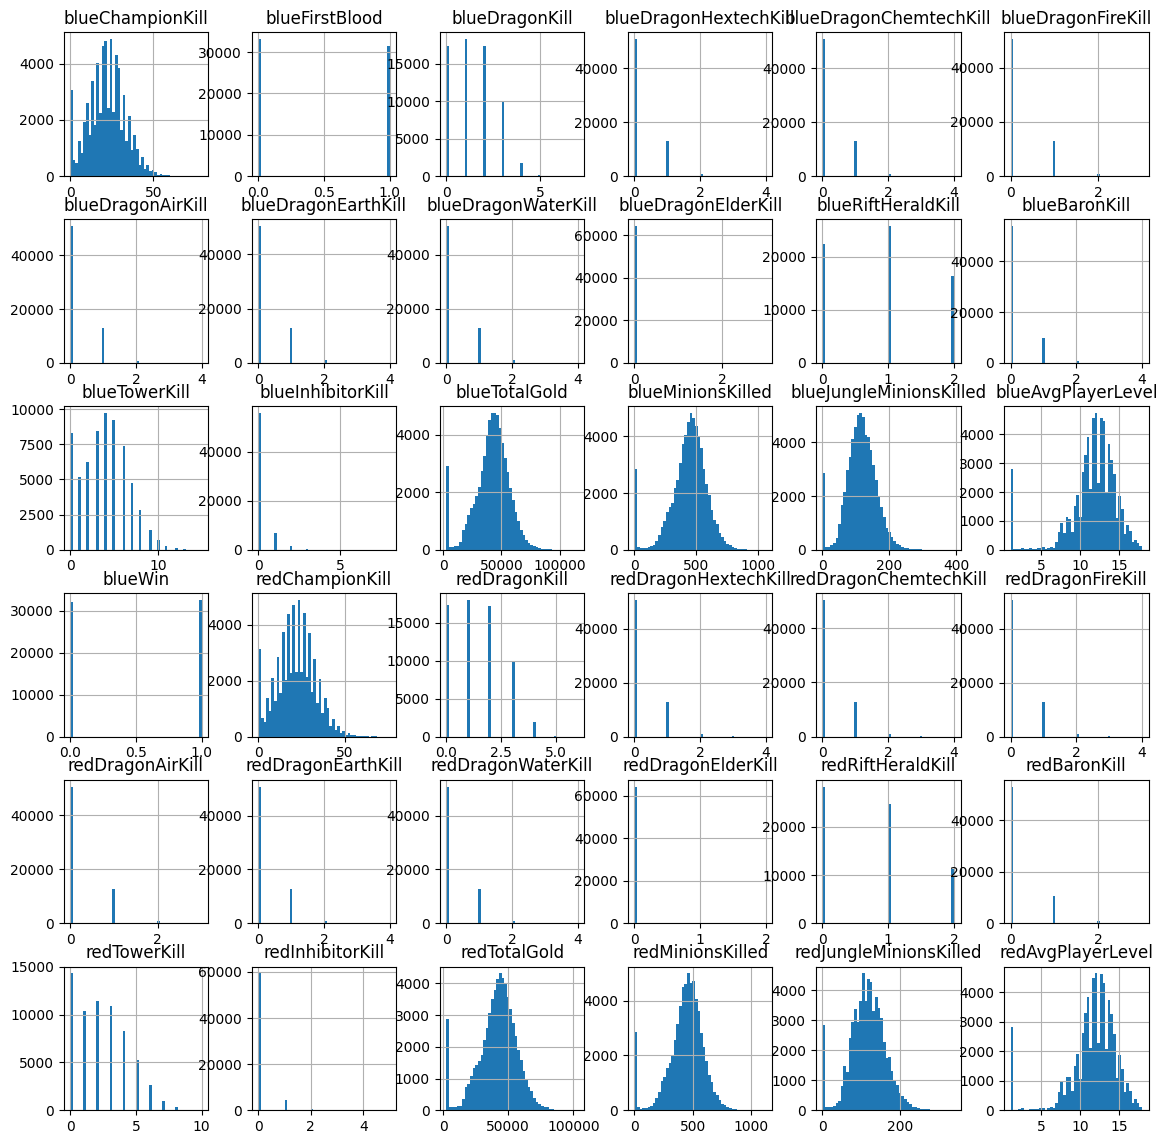

In [98]:
# Visualize data
# Look at feature hists

selected_dataset.hist(bins=50, figsize=(14,14))
plt.show()

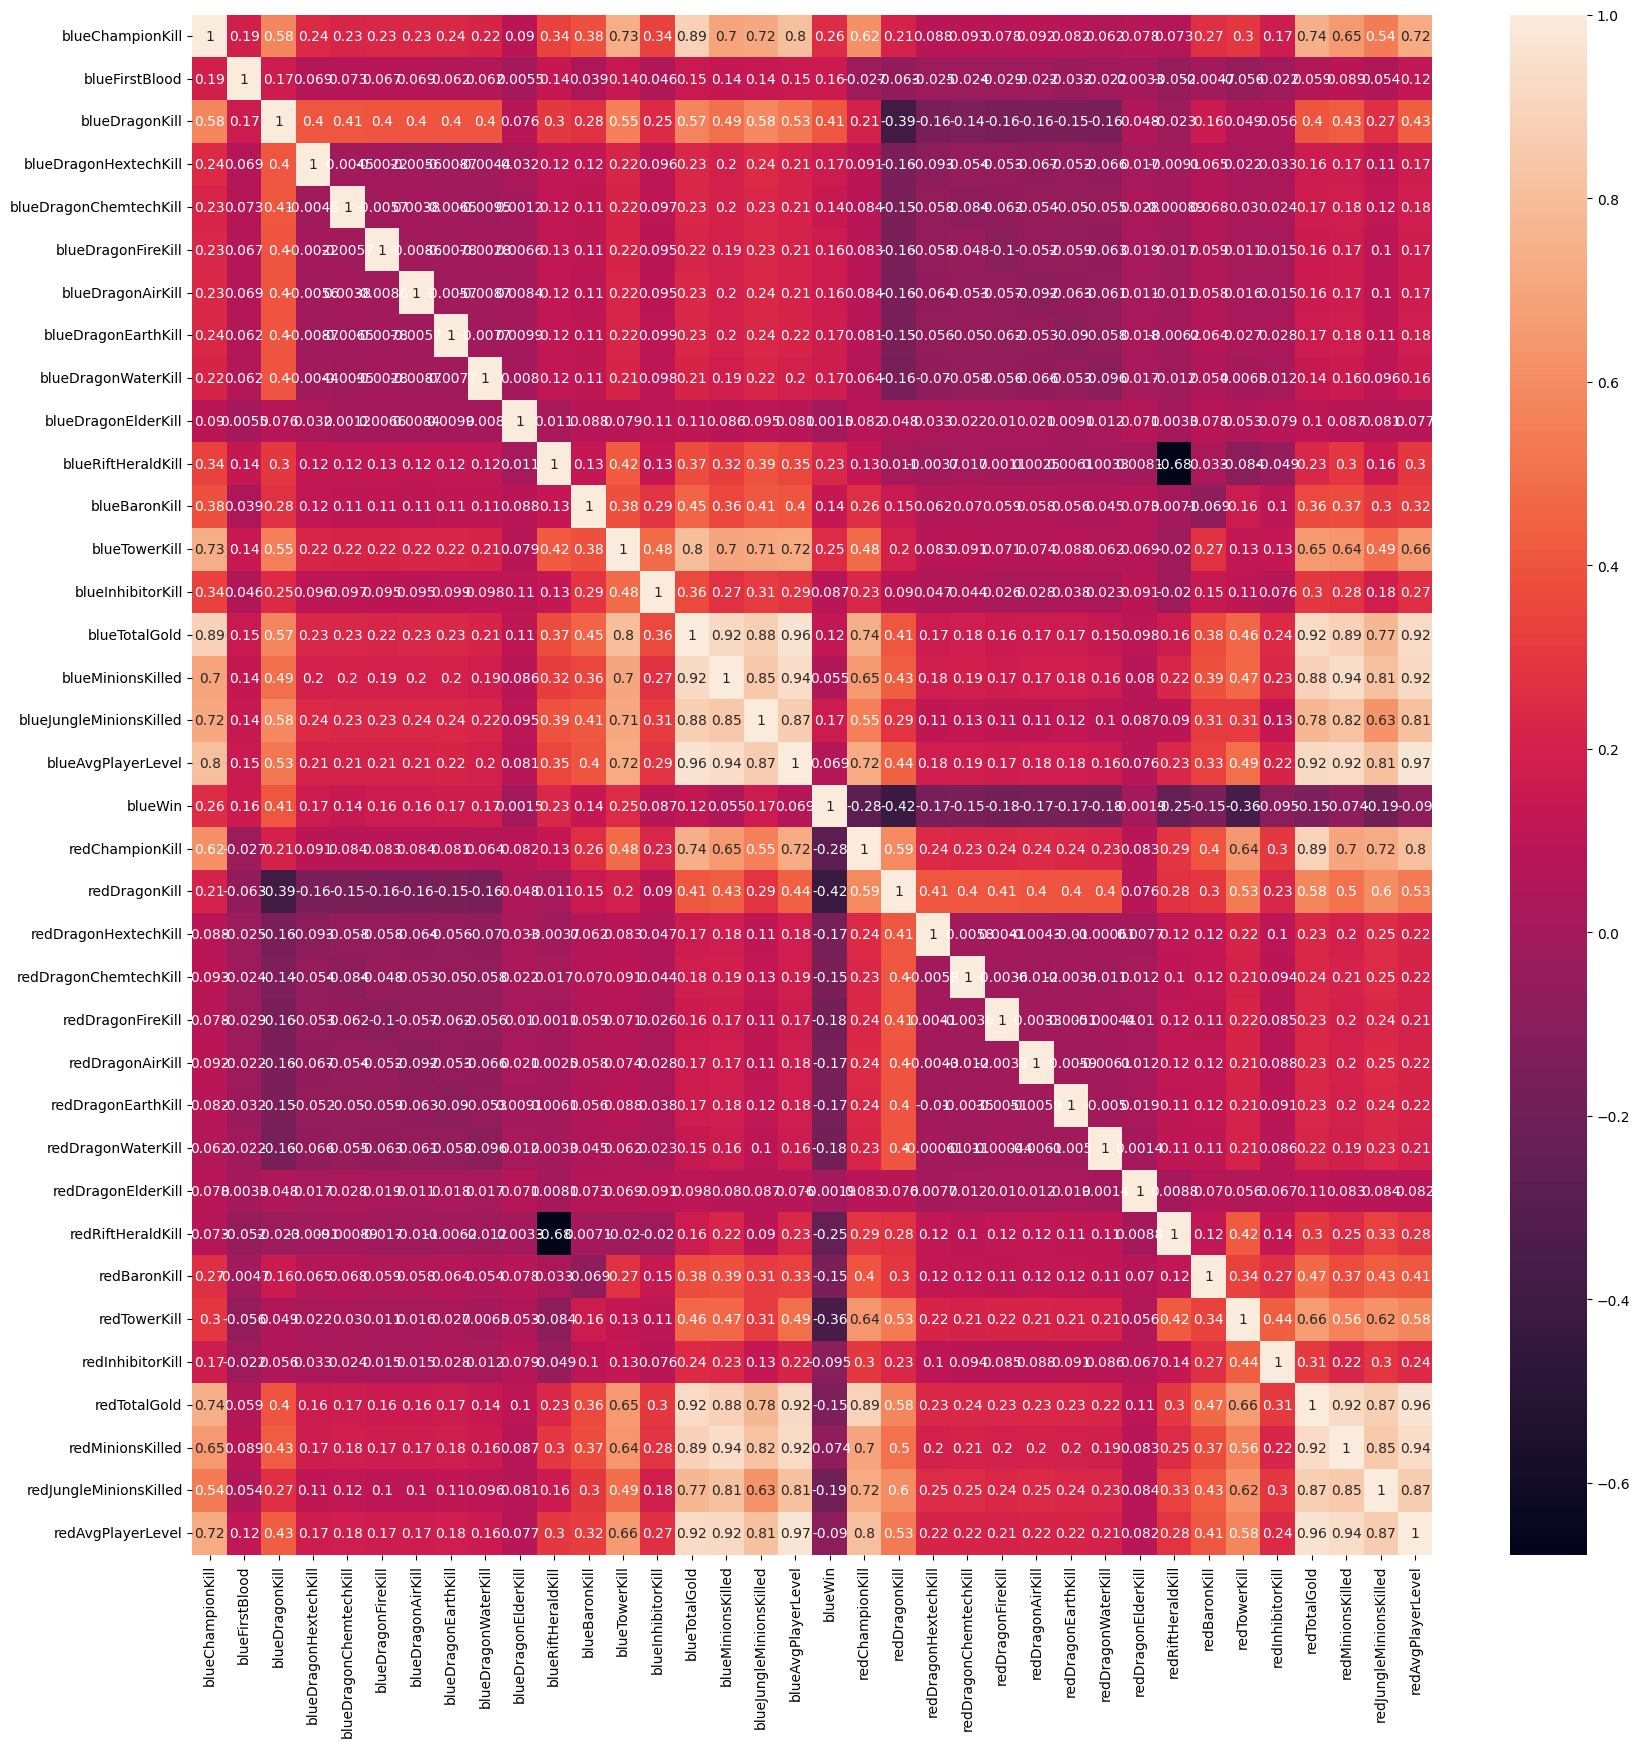

In [20]:
# Look at correlations
corr_matrix = selected_dataset.corr()
corr_plot , corr_ax = plt.subplots(figsize=(20,20))

sns.heatmap(data=corr_matrix, annot=True, ax=corr_ax)

plt.show()

In [110]:
### Feature engineering

# Create a hasDragonSoul feature
blueNonElderDragonKills = selected_dataset.blueDragonKill - selected_dataset.blueDragonElderKill
redNonElderDragonKills = selected_dataset.redDragonKill - selected_dataset.redDragonElderKill
# Has dragon soul if number of non elder dragon kills = 4
selected_dataset.insert(len(selected_dataset.columns), 'blueHasDragonSoul', blueNonElderDragonKills.map(lambda x: 1 if x == 4 else 0))
selected_dataset.insert(len(selected_dataset.columns), 'redHasDragonSoul', redNonElderDragonKills.map(lambda x: 1 if x == 4 else 0))

# Change minion kills per side to percent difference compared to total kills
eps = 1
minionKillDiff = selected_dataset.blueMinionsKilled - selected_dataset.redMinionsKilled
totalMinionKills = selected_dataset.blueMinionsKilled + selected_dataset.redMinionsKilled + eps
jungleMinionKillDiff = selected_dataset.blueJungleMinionsKilled - selected_dataset.redJungleMinionsKilled
totalJungleMinionKills = selected_dataset.blueJungleMinionsKilled + selected_dataset.redJungleMinionsKilled + eps

selected_dataset.insert(len(selected_dataset.columns), 'percentMinionDiff', minionKillDiff / totalMinionKills)
#selected_dataset.percentMinionDiff.map(lambda x : eps if x == 0 else x)
selected_dataset.insert(len(selected_dataset.columns), 'percentJungleMinionDiff', jungleMinionKillDiff / totalJungleMinionKills)
#selected_dataset.percentJungleMinionDiff.map(lambda x : eps if x == 0 else x)

# Rescale gold the same way
goldDiff = selected_dataset.blueTotalGold - selected_dataset.redTotalGold
totalGold = selected_dataset.blueTotalGold + selected_dataset.redTotalGold

selected_dataset.insert(len(selected_dataset.columns), 'percentTotalGoldDiff', goldDiff / totalGold + eps)
#selected_dataset.percentTotalGoldDiff.map(lambda x : eps if x == 0 else x)

# Remove specific dragon kills outside of elder and rescaled features
cut_features = ['blueDragonHextechKill',
                'blueDragonChemtechKill',
                'blueDragonFireKill',
                'blueDragonWaterKill',
                'blueDragonEarthKill',
                'blueDragonAirKill',
                'redDragonHextechKill',
                'redDragonChemtechKill',
                'redDragonFireKill',
                'redDragonWaterKill',
                'redDragonEarthKill',
                'redDragonAirKill',
                'blueMinionsKilled',
                'blueJungleMinionsKilled',
                'redMinionsKilled',
                'redJungleMinionsKilled',
                'blueTotalGold',
                'redTotalGold',
               ]

selected_dataset.drop(columns=cut_features, inplace=True)



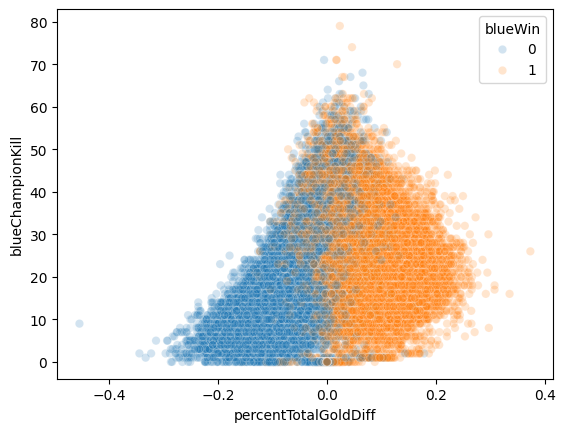

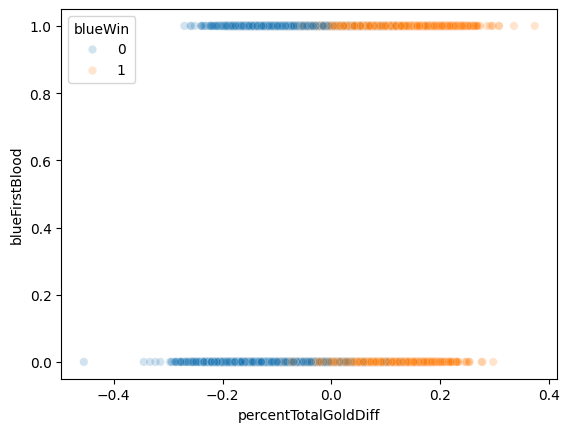

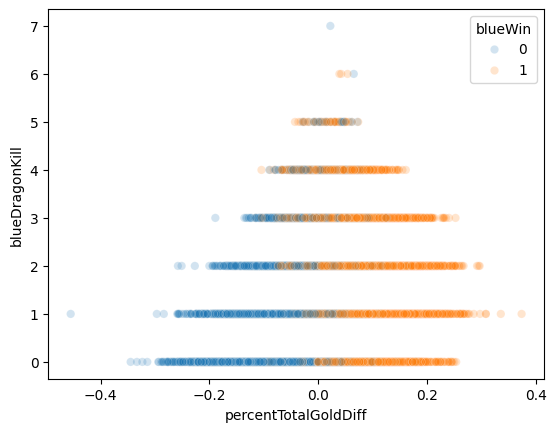

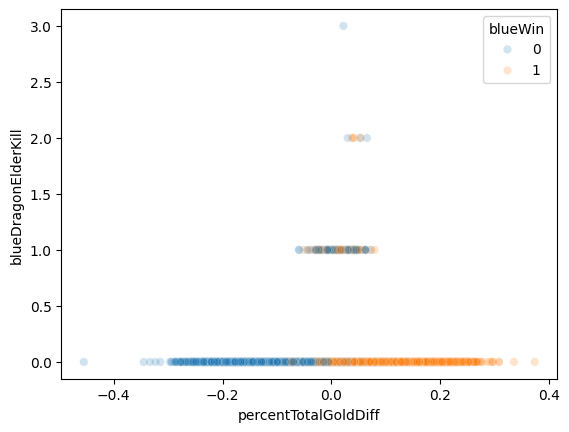

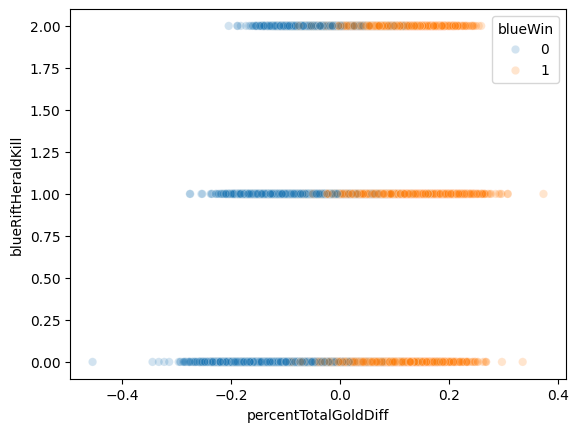

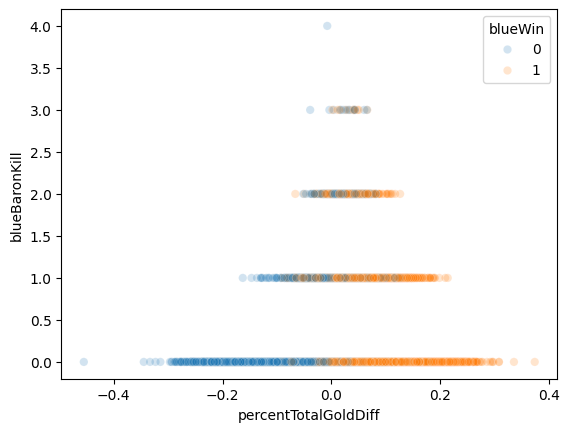

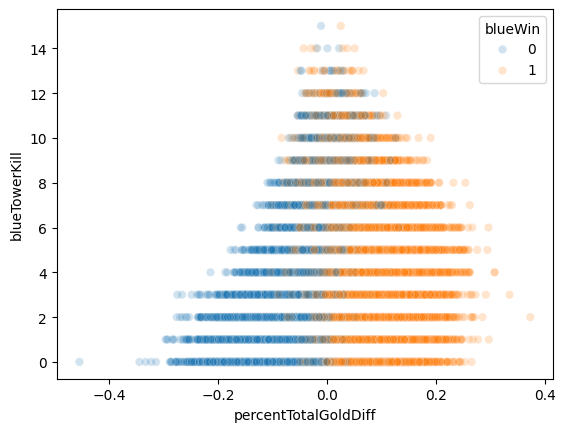

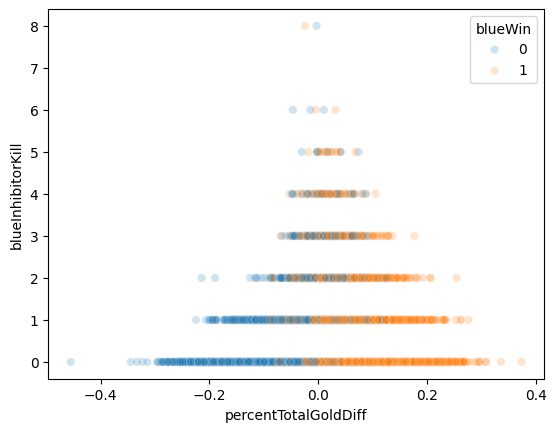

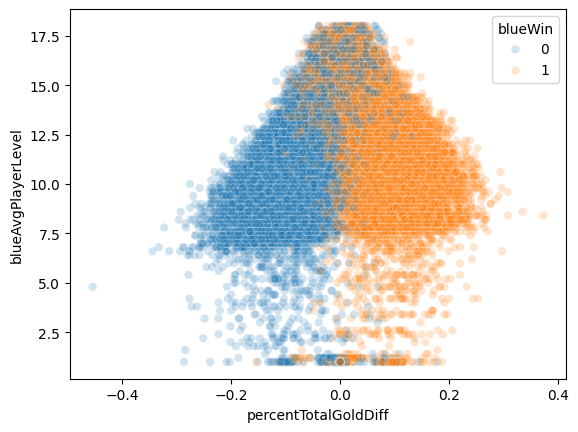

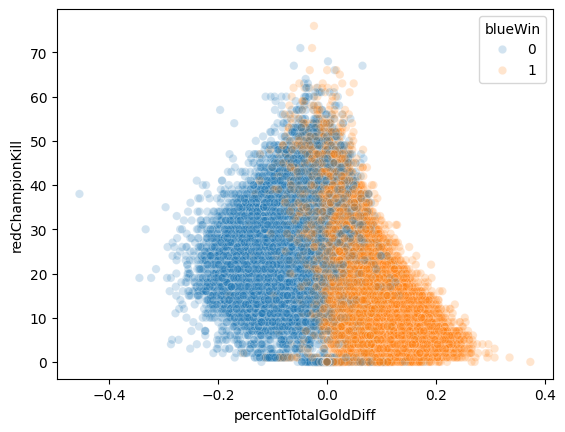

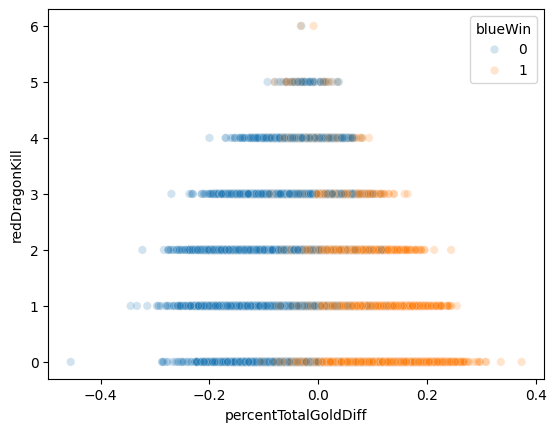

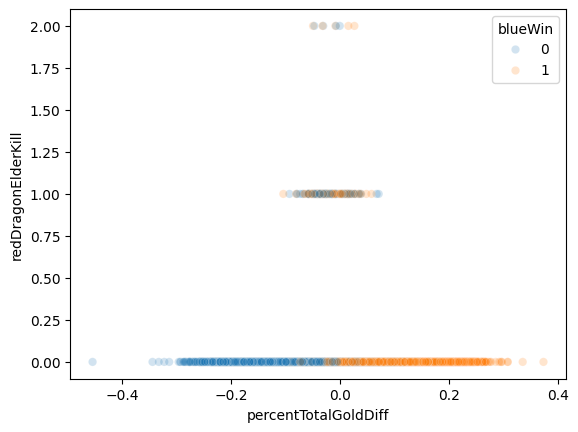

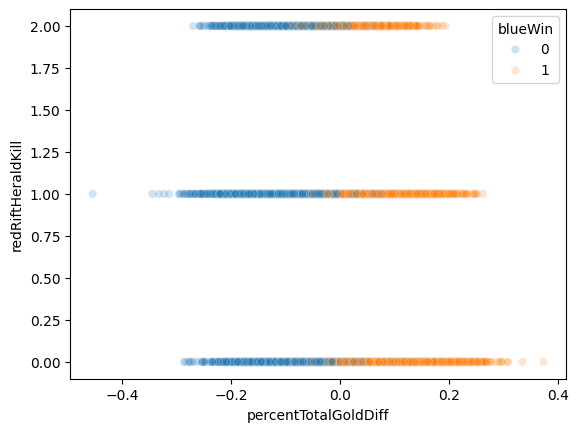

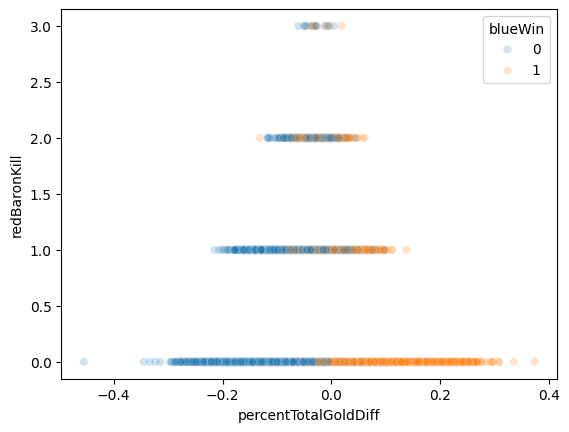

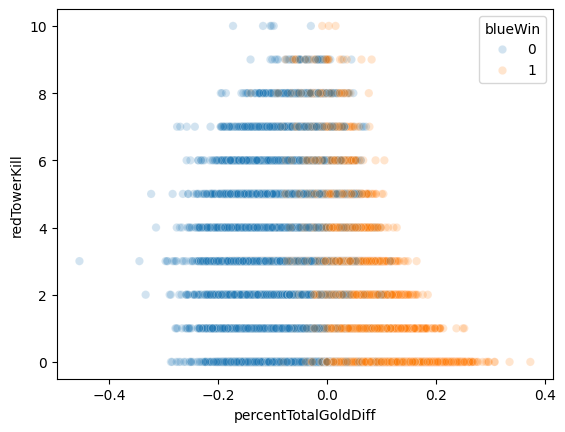

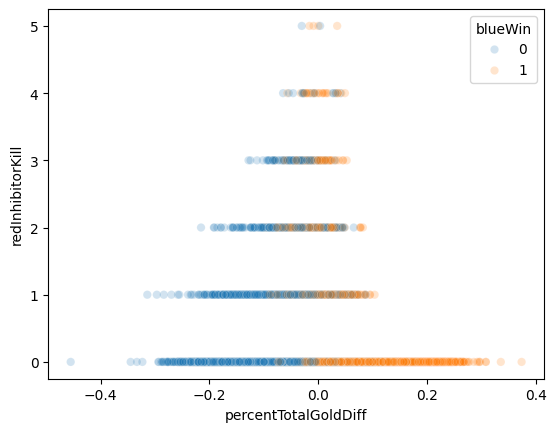

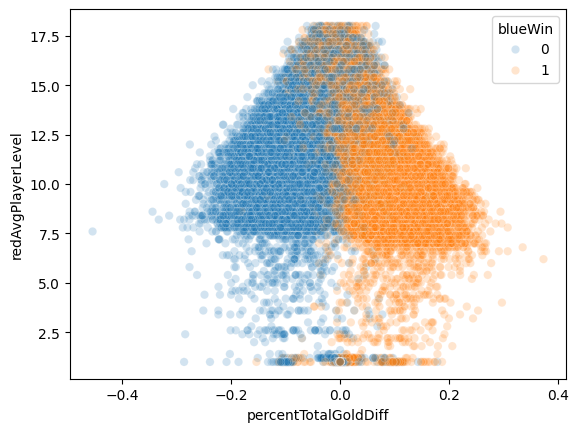

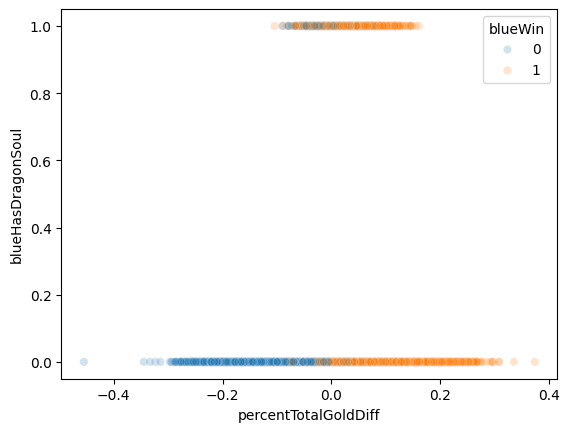

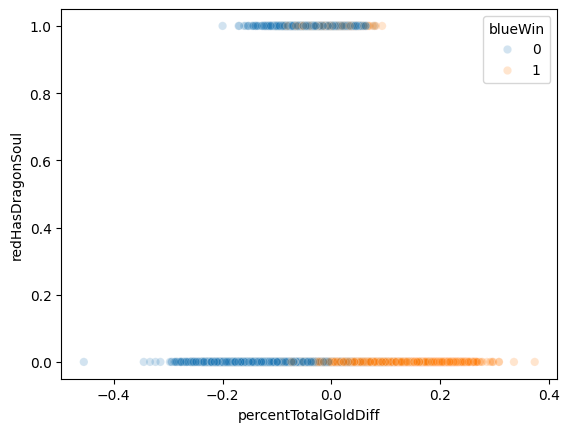

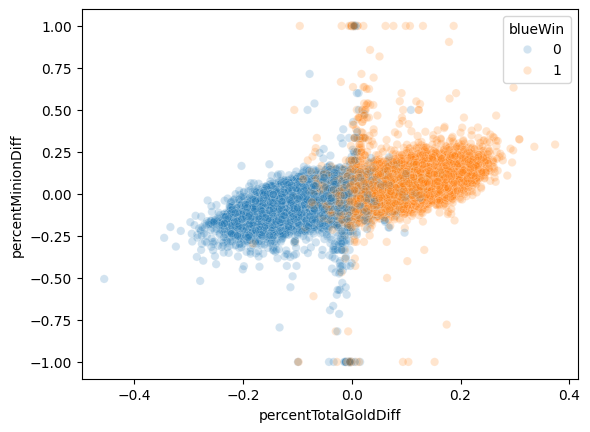

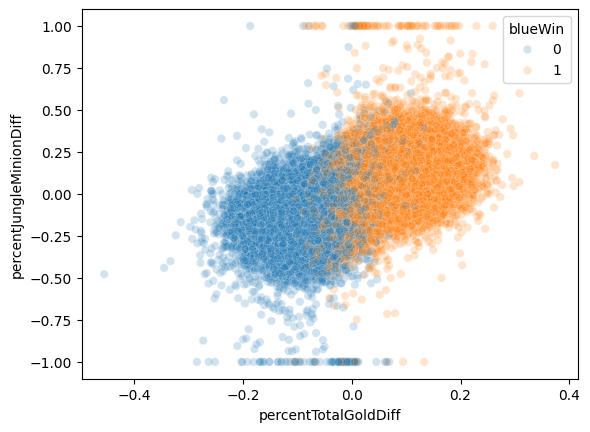

In [22]:
# Look at correlation scatterplots
utils.corr_scatter_plot(selected_dataset, selected_dataset.percentTotalGoldDiff, selected_dataset.blueWin, alpha=0.2)

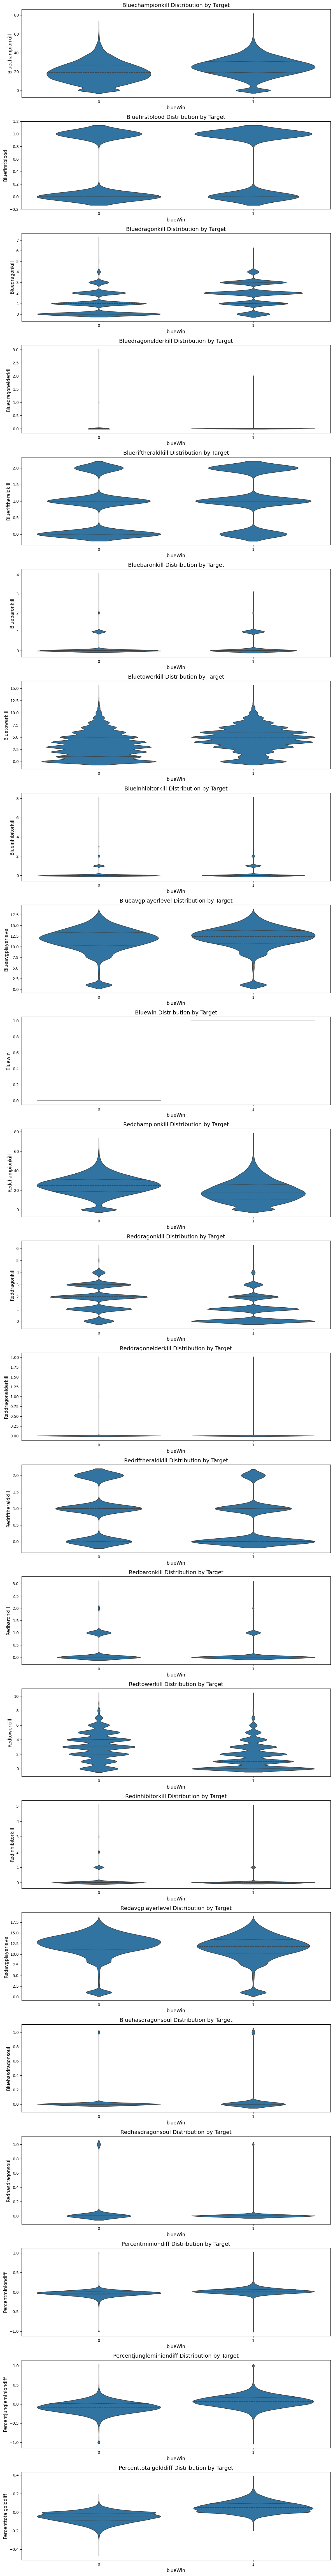

In [23]:
# Compare features based on win/loss
utils.binary_comparison_plot(selected_dataset, 'blueWin')

In [111]:
# Prepare training, validation, and test datasets for 20% game time

train_frac = 0.8
valid_frac = 0.1

train_set = selected_dataset.sample(frac = 0.8)
remaining_set = selected_dataset.drop(train_set.index)
valid_set = remaining_set.sample(frac = valid_frac / (1 - train_frac))
test_set = remaining_set.drop(valid_set.index)

# Separate wins
train_wins = train_set.pop('blueWin')
valid_wins = valid_set.pop('blueWin')
test_wins = test_set.pop('blueWin')

print(selected_dataset.shape, train_set.shape, valid_set.shape, test_set.shape)


(64556, 23) (51645, 22) (6456, 22) (6455, 22)


In [112]:
# Convert dataframes to tensors
train_data = tf.convert_to_tensor(train_set, dtype='float32')
train_labels = tf.convert_to_tensor(train_wins, dtype='float32')

valid_data = tf.convert_to_tensor(valid_set, dtype='float32')
valid_labels = tf.convert_to_tensor(valid_wins, dtype='float32')

input_shape = train_data.shape[1]
# Define batches

#train_batched = get_batch(train_data, train_labels, 64)
#valid_batched = get_batch(valid_data, valid_labels, 64)

print(tf.shape(train_data), tf.shape(train_labels))

tf.Tensor([51645    22], shape=(2,), dtype=int32) tf.Tensor([51645], shape=(1,), dtype=int32)


In [113]:
# Define model
model = tf.keras.models.Sequential([
    tf.keras.layers.BatchNormalization(input_shape=(22,)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Choose optimizer and loss function
optimizer = tf.keras.optimizers.AdamW(learning_rate=0.0001)
loss_func = tf.keras.losses.BinaryCrossentropy()

# Compile and train model
model.compile(optimizer=optimizer, loss = loss_func, metrics=['binary_accuracy'])
model.fit(x=train_data, y=train_labels, epochs = 10, batch_size=64)

# Test model
model.evaluate(valid_data, valid_labels)

Epoch 1/10
807/807 [==============================] - 5s 5ms/step - loss: 0.3982 - binary_accuracy: 0.8172
Epoch 2/10
807/807 [==============================] - 4s 5ms/step - loss: 0.3671 - binary_accuracy: 0.8285
Epoch 3/10
807/807 [==============================] - 4s 5ms/step - loss: 0.3563 - binary_accuracy: 0.8303
Epoch 4/10
807/807 [==============================] - 4s 5ms/step - loss: 0.3501 - binary_accuracy: 0.8316
Epoch 5/10
807/807 [==============================] - 4s 5ms/step - loss: 0.3449 - binary_accuracy: 0.8342
Epoch 6/10
807/807 [==============================] - 4s 5ms/step - loss: 0.3404 - binary_accuracy: 0.8363
Epoch 7/10
807/807 [==============================] - 4s 5ms/step - loss: 0.3388 - binary_accuracy: 0.8372
Epoch 8/10
807/807 [==============================] - 4s 5ms/step - loss: 0.3355 - binary_accuracy: 0.8379
Epoch 9/10
807/807 [==============================] - 4s 5ms/step - loss: 0.3333 - binary_accuracy: 0.8387
Epoch 10/10
202/202 [================

[0.3161601126194, 0.8466542959213257]

In [ ]:
# Test manual train
# Define training step
@tf.function
def train_step(match_states, outcomes):
    with tf.GradientTape() as tape:  
        predictions = tf.squeeze(model.call(match_states))
        loss = loss_func(outcomes, predictions)
        
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(outcomes, predictions)


# Define testing step
@tf.function
def test_step(match_states, outcomes):
    predictions = tf.squeeze(model.call(match_states))
    loss = loss_func(outcomes, predictions)

    valid_loss(loss)
    valid_accuracy(outcomes, predictions)

# Plots
loss_plot, loss_ax = plt.subplots()
loss_ax.grid()
plt.xlabel("Epochs")
plt.ylabel("Loss")
dh = display.display(loss_plot, display_id=True)

# Run
EPOCHS = 100

x_plot, y_plot = [], []

for epoch in tqdm(range(EPOCHS)):
    train_loss.reset_states()

    for match_states, outcomes in train_batched:
        train_step(match_states, outcomes)

    
    x_plot.append(epoch)
    y_plot.append(train_loss.result().numpy())
    loss_ax.plot(x_plot, y_plot, color='blue')
    dh.update(loss_plot)
    time.sleep(0.1)

    
    if epoch % 10 == 0:
        model.save_weights(output_prefix)
        
plt.close()

for match_states, outcomes in valid_batched:
    test_step(match_states, outcomes)

print(f'Loss: {train_loss.result()}, 'f'Accuracy: {train_accuracy.result()}, 'f'Validation Loss: {valid_loss.result()}, 'f'Validation Accuracy: {valid_accuracy.result()}')
# Set output
output_dir = './output'
output_prefix = os.path.join(output_dir, "DNN_2l_20")

model.save_weights(output_prefix)